# Neural ODE

In [1]:
# TODO: Replace print with logging

### 1. SETUP

Import useful packages and pre-defined helper functions

In [2]:
import torch
import torch.nn as nn
import numpy as np

import utilities as utilities
import matplotlib.pyplot as plt

Set parameters

In [3]:
model_object_dict = {}

# Model Activation Functions
activation_functions = [
    nn.ReLU,
    nn.Sigmoid,
    nn.SiLU,
    nn.Tanh,
    nn.ELU,
    nn.Hardsigmoid,
    nn.GELU,
]

# Model Optimizer
model_optimizer = torch.optim.SGD

# Model Loss Function
model_lossfn = nn.BCELoss
# NOTE: nn.BCELoss has no sigmoid built-in
# Require inputs to have gone through the sigmoid activation function prior


# Model Architecture
hidden_dim = 8  # NOTE: hvis hidden dim er for stor, blir det da for vanskelig å plotte trajectory som "ligner" på slik input dataen er i 2D?
hidden_internal_dim = 8  # internal dim in y' : p in (p x m)
num_hidden_layers = 7  # number of time steps
method = ["neural", "euler", "rk4"][1]
variant = ["standard", "UT"][1]

# Epochs
n_epochs = 50

# Plotting
color_label_dict = {0: "blue", 1: "red"}

# Dataset
n_points = 2000  # Make 1000 samples
dataset_type = ["spiral", "cirle"][0]  # Choose between "spiral" and "circle"

### 2. Data Preparation

#### 2.1 Load and prepare dataset

Shape of synthetic dataset (X, y): (torch.Size([4000, 2]), torch.Size([4000]))


/Users/martineh/anaconda3/envs/resnet/lib/python3.9/site-packages/matplotlib/collections.py:1109: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


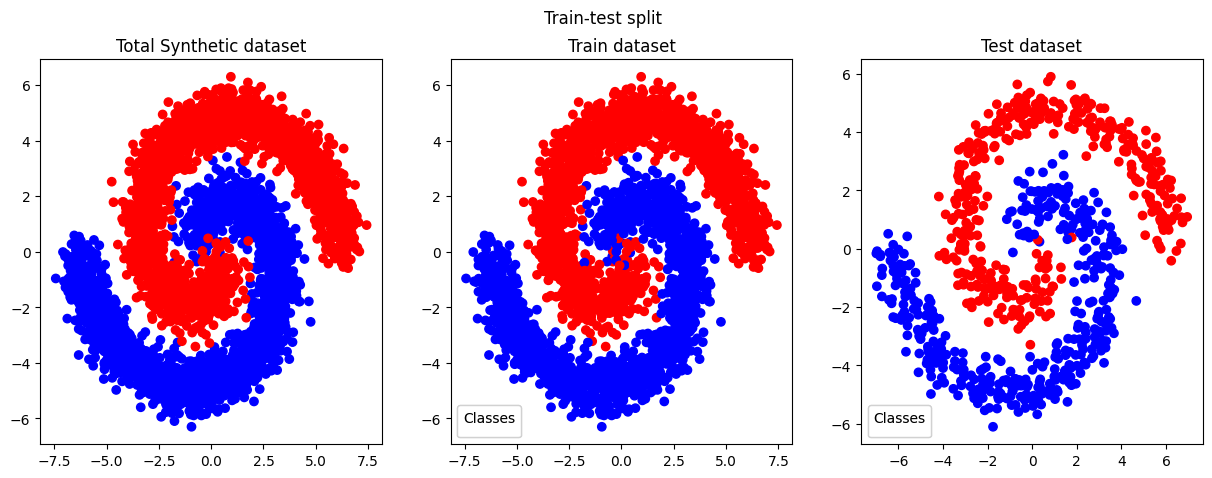

In [4]:
# Load dataset (X, y)
if dataset_type == "spiral":
    # Sprial data
    X, y = utilities.generate_spiral_data(n_points, noise=0.5, degree=360)

elif dataset_type == "circle":
    # Circle data
    X, y = utilities.generate_circle_data(n_points, noise=0.05)

else:
    raise ValueError(
        f"Dataset type {dataset_type} is not defined. Please try another type!"
    )

# Load to torch tensor
# Train test split
(
    train_dataloader,
    test_dataloader,
    train_data,
    test_data,
    X_train,
    y_train,
    X_test,
    y_test,
) = utilities.get_dataloader_from_numpy_dataset(
    X, y, plot_splitting=True, color_label_dict=color_label_dict
)

#### 2.2 Get dim of data

In [5]:
# Get dim
input_dim = X.shape[-1]
if len(y.shape) == 1:
    output_dim = 1
else:
    output_dim = y.shape[-1]

print(f"dim of input data: {input_dim}")
print(f"dim of output data: {output_dim}")

dim of input data: 2
dim of output data: 1


### 3. Neural ODE Implementation

In [6]:
class ODEBlock(nn.Module):
    """
    y' = dy/dt

    Args:
        nn (_type_): _description_
    """

    def __init__(self, variant, sigma, m, p=None):
        super(ODEBlock, self).__init__()
        self.variant = variant
        self.m = m
        self.p = p if p else m  # Default to m if p is None
        self.sigma = sigma  # activation function

        if self.variant == "standard":
            self.W = nn.Parameter(torch.randn(self.m, self.m))
            self.b = nn.Parameter(torch.randn(self.m))
        elif self.variant == "UT":
            self.U = nn.Parameter(torch.randn(self.p, self.m))
            self.W = nn.Parameter(torch.randn(self.p, self.m))
            self.b = nn.Parameter(torch.randn(self.p))
        else:
            raise ValueError("Invalid variant type")

    def forward(self, y):
        # y shape : batch size x m

        if self.variant == "standard":
            Wy = torch.mm(self.W, y.T).T
            b = torch.mul(torch.ones(y.shape[0], self.b.shape[0]), self.b)
            return self.sigma(Wy + b)  # torch.mm : matrix multiplication
        elif self.variant == "UT":
            Wy = torch.mm(self.W, y.T).T
            b = torch.mul(torch.ones(y.shape[0], self.b.shape[0]), self.b)
            # print(self.sigma(Wy + b).shape, self.U.shape)
            # print(Wy, b)
            return torch.mm(self.U.T, self.sigma(Wy + b).T).T


class NeuralODE(nn.Module):
    """

    FIXME: What about multiple steps?

    Args:
        nn (_type_): _description_
    """

    def __init__(
        self,
        input_dim,
        hidden_dim,
        hidden_internal_dim,
        output_dim,
        num_hidden_layers,
        sigma,
        method,
        variant,
    ):
        super(NeuralODE, self).__init__()
        self.method = method
        self.variant = variant
        self.num_hidden_layers = num_hidden_layers  # how many time steps
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.hidden_internal_dim = hidden_internal_dim
        self.output_dim = output_dim
        self.sigma = sigma()
        self.h = 0.05  # constant step size

        self.input_layer = nn.Linear(
            in_features=input_dim, out_features=hidden_dim, bias=False
        )

        self.ode = ODEBlock(
            variant=variant, sigma=self.sigma, m=hidden_dim, p=hidden_internal_dim
        )  # y'

        self.classifier = nn.Sequential(
            nn.Linear(in_features=hidden_dim, out_features=output_dim)
        )

        # logits to prob
        self.logits_to_prob = nn.Sequential(nn.Sigmoid())

    def forward(self, x):
        # track transformation of the data
        # samples in batch - num hidden units - num hidden layers + 1 # FIXME: Do i need +1??
        x_transformed = torch.empty(
            x.shape[0], self.hidden_dim, self.num_hidden_layers + 1
        )

        # input layer (increase dimension)
        x = self.input_layer(x)

        # save tranformation of x at time t0 (after dim increase)
        x_transformed[:, :, 0] = x

        # ODE solver
        for t in range(self.num_hidden_layers):  # how many time steps
            if self.method == "neural":
                x = self.ode(x)
            elif self.method == "euler":
                x = x + self.h * self.ode(x)
            elif self.method == "rk4":
                k1 = self.ode(x)
                k2 = self.ode(x + self.h * k1 / 2.0)
                k3 = self.ode(x + self.h * k2 / 2.0)
                k4 = self.ode(x + self.h * k3)

                x = x + self.h * (k1 + 2.0 * k2 + 2.0 * k3 + k4) / 6.0

            else:
                raise ValueError("Invalid method type")

            # save tranformation of x for each time step
            x_transformed[:, :, t + 1] = x

        # outout layers
        # classifier to binary channel
        # and from logits to probabilities
        x = self.classifier(x)
        x = self.logits_to_prob(x)

        return x.squeeze(), x_transformed

### 4. Training

In [7]:
# NOTE:
# med spiral dataset fungerer hidden_dim = 3, og man kan da plotte resultatet i 3d. Nettverket fungerer ikke for cirkel data.


# ut fungerer ikke med rk4, men fungerer fint med euler for cirkel data. Følgende separerer prikkene bra. Men hvorfor er de ikke alltid separert SELV OM modellen predikerer korrekt?
# hidden_dim = 16
# hidden_internal_dim = 24 # internal dim in y' : p in (p x m)
# num_hidden_layers = 10 # number of time steps
# method = ["neural", "euler", "rk4"][1]
# variant = ["standard", "UT"][1]

# helt likt fungerer ikke for sprial data, men dersom man ender til standard metode fungerer det for spiral
# hidden_dim = 16
# hidden_internal_dim = 24 # internal dim in y' : p in (p x m)
# num_hidden_layers = 10 # number of time steps
# method = ["neural", "euler", "rk4"][1]
# variant = ["standard", "UT"][0]


Activation function ReLU:

----> EPOCH 0 of 100:
Train loss: 0.40873 | Train accuracy: 76.12%
Test loss: 16.00000 | Test accuracy: 84.00%

----> EPOCH 1 of 100:
Train loss: 0.29754 | Train accuracy: 86.06%
Test loss: 8.25000 | Test accuracy: 91.75%

----> EPOCH 2 of 100:
Train loss: 0.20041 | Train accuracy: 93.09%
Test loss: 9.00000 | Test accuracy: 91.00%

----> EPOCH 3 of 100:
Train loss: 0.17199 | Train accuracy: 93.97%
Test loss: 1.25000 | Test accuracy: 98.75%

----> EPOCH 4 of 100:
Train loss: 0.10441 | Train accuracy: 96.38%
Test loss: 0.62500 | Test accuracy: 99.38%

----> EPOCH 5 of 100:
Train loss: 0.14418 | Train accuracy: 94.72%
Test loss: 1.37500 | Test accuracy: 98.62%

----> EPOCH 6 of 100:
Train loss: 0.09291 | Train accuracy: 96.84%
Test loss: 1.75000 | Test accuracy: 98.25%

----> EPOCH 7 of 100:
Train loss: 0.07257 | Train accuracy: 97.66%
Test loss: 0.62500 | Test accuracy: 99.38%

----> EPOCH 8 of 100:
Train loss: 0.10973 | Train accuracy: 95.97%
Test loss: 10.12

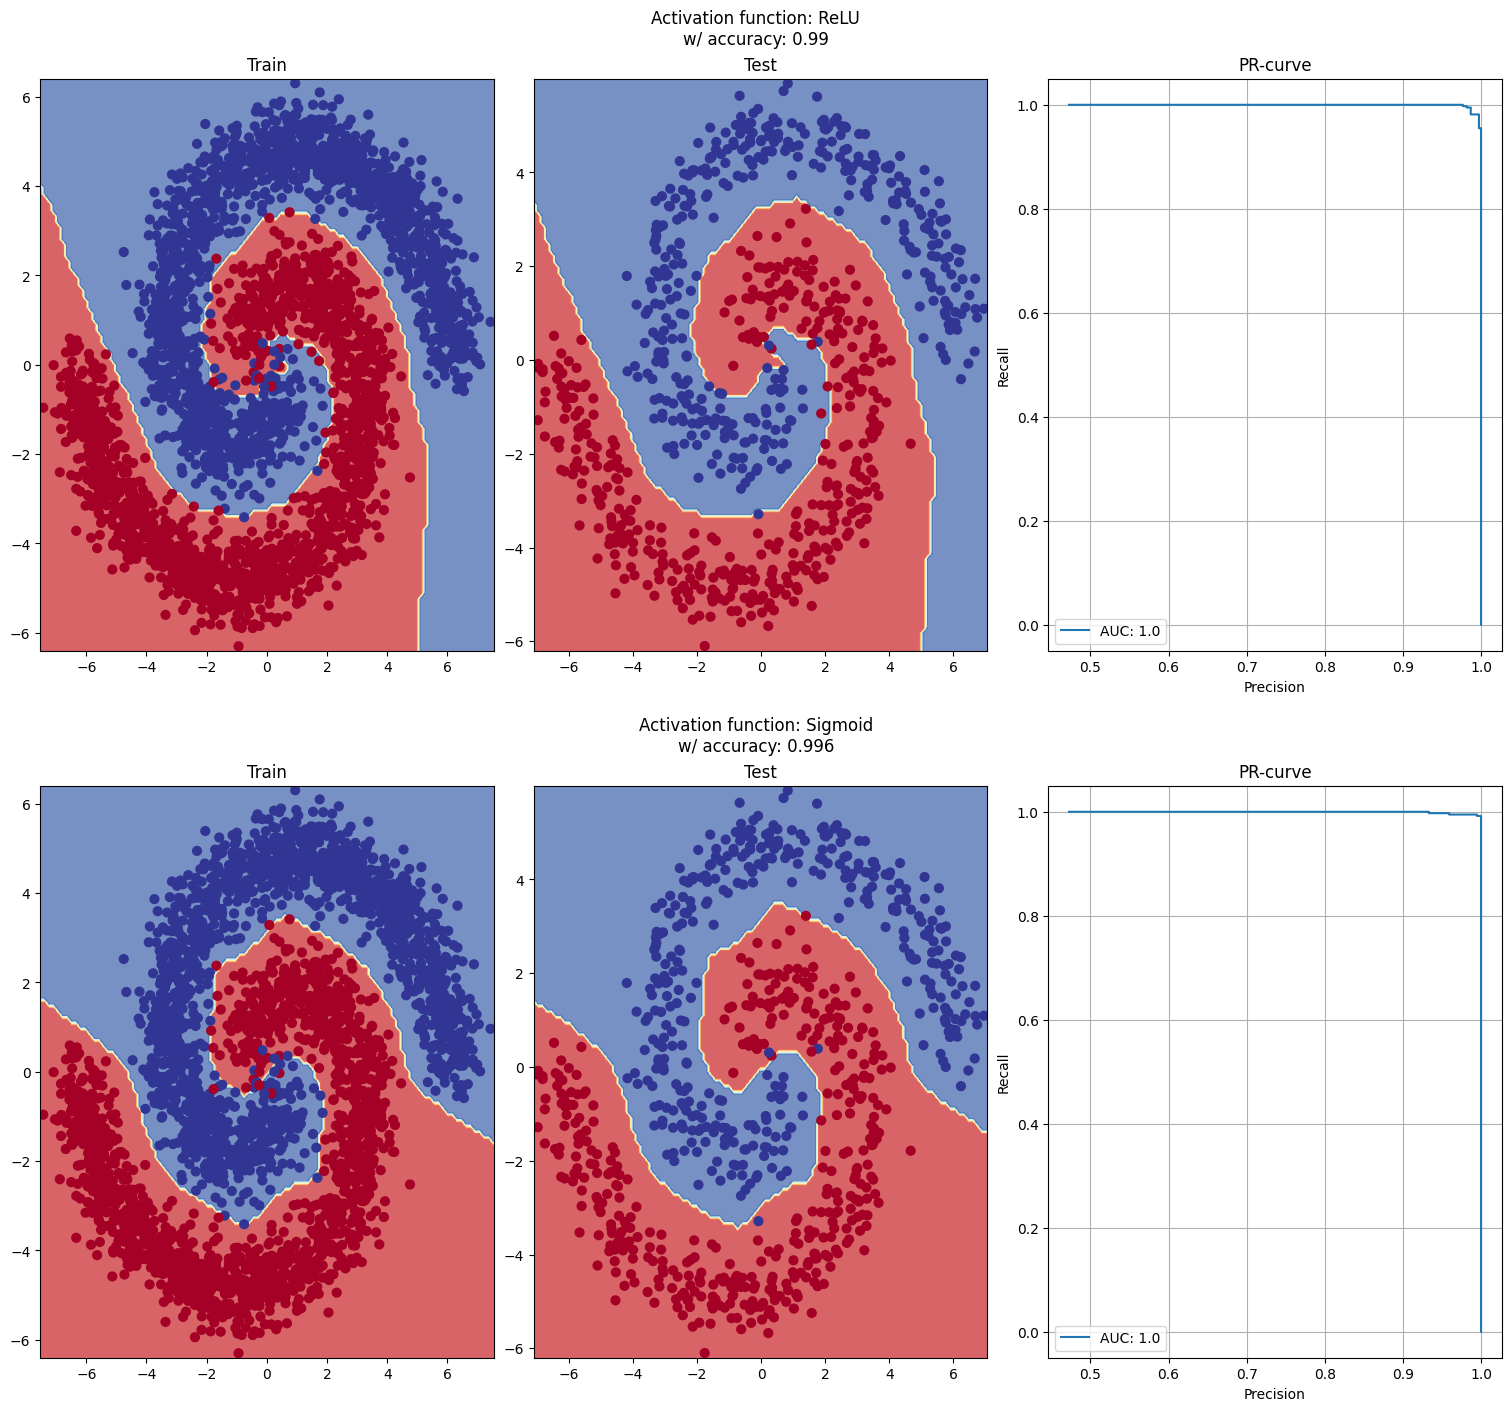

In [8]:
# Initialize plot for evaluation if we are comparing different actication function
if len(activation_functions) > 1:
    fig = plt.figure(constrained_layout=True, figsize=(15, 7 * len(activation_functions)))
    axs = fig.subfigures(len(activation_functions), 1)

for a, activation_function in enumerate(activation_functions):
    print(f"\nActivation function {activation_function.__name__}:\n")

    # Create 1x3 subplots on each row
    if len(activation_functions) > 1:
        subaxs = axs[a].subplots(1, 3)
    else:
        fig, subaxs = plt.subplots(1, 3, figsize=(15, 5))

    # Initialize model
    torch.manual_seed(42)  # set seed for random parameters in model
    model = NeuralODE(
        input_dim=input_dim,
        hidden_dim=hidden_dim,
        hidden_internal_dim=hidden_internal_dim,
        output_dim=output_dim,
        num_hidden_layers=num_hidden_layers,  # num time steps
        sigma=activation_function,
        variant=variant,
        method=method,
    )

    # Select optimizer and loss function
    loss_fn = model_lossfn()
    # Create an optimizer
    optimizer = model_optimizer(params=model.parameters(), lr=0.1)

    # Train and test for multiple epochs
    train_loss_per_epoch = []
    test_loss_per_epoch = []
    train_acc_per_epoch = []
    test_acc_per_epoch = []

    for epoch in range(n_epochs):
        print(f"----> EPOCH {epoch} of {n_epochs}:")
        train_loss, train_acc = utilities.train_model(
            model=model,
            data_loader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            verbose=False,
        )

        test_loss, test_acc = utilities.test_model(
            model=model, data_loader=test_dataloader, loss_fn=loss_fn
        )

        train_loss_per_epoch.append(train_loss.detach().numpy())
        train_acc_per_epoch.append(train_acc)

        test_loss_per_epoch.append(test_loss.detach().numpy())
        test_acc_per_epoch.append(test_acc)

    # Plot decision boundaries for training and test sets
    for i, kwargs in enumerate(
        zip(
            [X_train.numpy(), X_test.numpy()],
            [y_train.numpy(), y_test.numpy()],
            ["Train", "Test"],
        )
    ):
        X_data, y_data, title = kwargs
        xx, yy, y_grid_pred = utilities.decision_boundary_grid(
            model=model, X=X_data, y=y_data
        )
        subaxs[i].contourf(xx, yy, y_grid_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
        subaxs[i].scatter(X_data[:, 0], X_data[:, 1], c=y_data, s=40, cmap=plt.cm.RdYlBu)
        subaxs[i].set_xlim(xx.min(), xx.max())
        subaxs[i].set_ylim(yy.min(), yy.max())
        subaxs[i].set_title(title)

    # Metrics
    probs, x_transformed = model(X_test)
    preds = torch.round(probs)
    target = y_test.type(torch.int)
    acc_metric = utilities.BinaryAccuracy()
    prc_metric = utilities.BinaryPrecisionRecallCurve()

    bprc = prc_metric(probs, target)  # Precision, recall, threshold
    subaxs[2].plot(
        bprc[0], bprc[1], label=f"AUC: {np.round(utilities.auc(bprc[1], bprc[0]), 3)}"
    )  # auc(recall, precision)
    subaxs[2].grid()
    subaxs[2].set_xlabel("Precision")
    subaxs[2].set_ylabel("Recall")
    subaxs[2].legend()
    subaxs[2].set_title("PR-curve")

    # Confusion matrix
    confusion_matrix = utilities.confusion_matrix(target, preds.detach())

    try:
        axs[a].suptitle(
            f"Activation function: {activation_function.__name__}\n"
            f"w/ accuracy: {np.round(acc_metric(preds, target).item(), 3)}"
        )
    except NameError:
        plt.suptitle(
            f"Activation function: {activation_function.__name__}\n"
            f"w/ accuracy: {np.round(acc_metric(preds, target).item(), 3)}"
        )
        plt.tight_layout()

    # Test metrics
    test_metrics, x_transformed_array, y_transformed_array = utilities.test_model(
        model=model,
        data_loader=test_dataloader,
        loss_fn=loss_fn,
        evaluate=True,  # get final result(evaluate=True)
    )

    # Transformation of data through time stepping
    # Create reduced array
    # 1. Remove dim due to batches
    # 2. Transform form torch tensor to numpy array
    x_transformed_reduced, y_transformed_reduced = utilities.preprocess_transformed_array(
        x_transformed_array, y_transformed_array
    )
    # Color for reduced labels
    color_transformed_reduced = np.vectorize(color_label_dict.get)(y_transformed_reduced)

    # Save result as model privat varibles
    model.test_metrics = test_metrics
    model.x_transformed_array = x_transformed_array
    model.y_transformed_array = y_transformed_array
    model.x_transformed_reduced = x_transformed_reduced
    model.y_transformed_reduced = y_transformed_reduced
    model.color_transformed_reduced = color_transformed_reduced
    model.train_loss_per_epoch = train_loss_per_epoch
    model.test_loss_per_epoch = test_loss_per_epoch
    model.train_acc_per_epoch = train_acc_per_epoch
    model.test_acc_per_epoch = test_acc_per_epoch
    model.confusion_matrix = confusion_matrix

    model_object_dict[activation_function.__name__] = model

plt.show()

## Plot transformation of X points through time stepping

In [13]:
plot_model = model_object_dict["Sigmoid"]

### 3D plot for each time step (works well for hidden dim = 3)

In [14]:
utilities.plot_transformation_3d(
    x_transformed_reduced=plot_model.x_transformed_reduced,
    color_transformed_reduced=plot_model.color_transformed_reduced,
    static=False,
    interactive=True,
)

### Plot 2D with PCA to reduce dimension

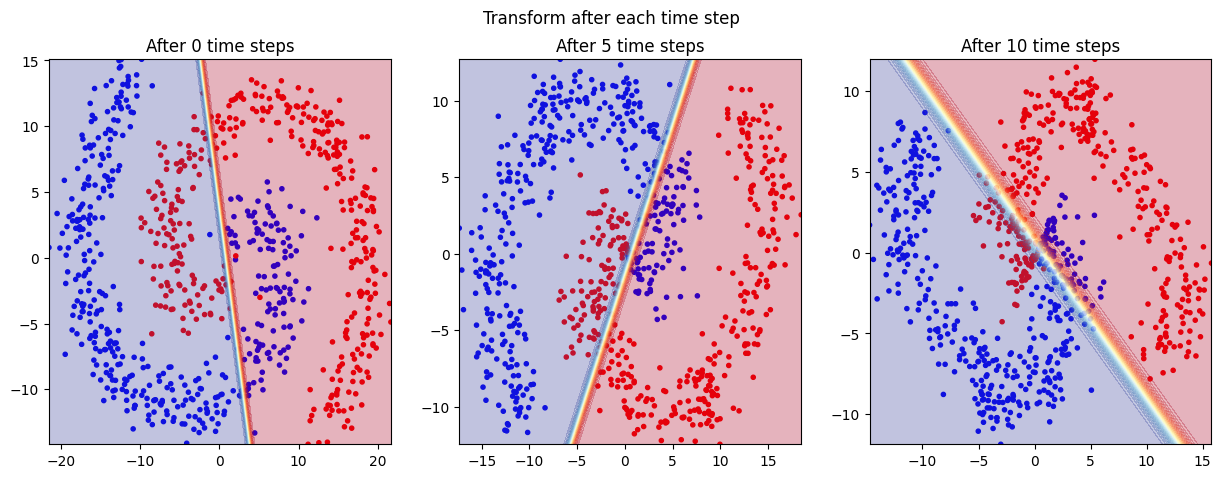

In [15]:
utilities.plot_transformation_2d(
    x_transformed_reduced=plot_model.x_transformed_reduced,
    color_transformed_reduced=plot_model.color_transformed_reduced,
    show_decision_boundary=True,
    model=model,
)

## Loss, accuracy and confusion matrix

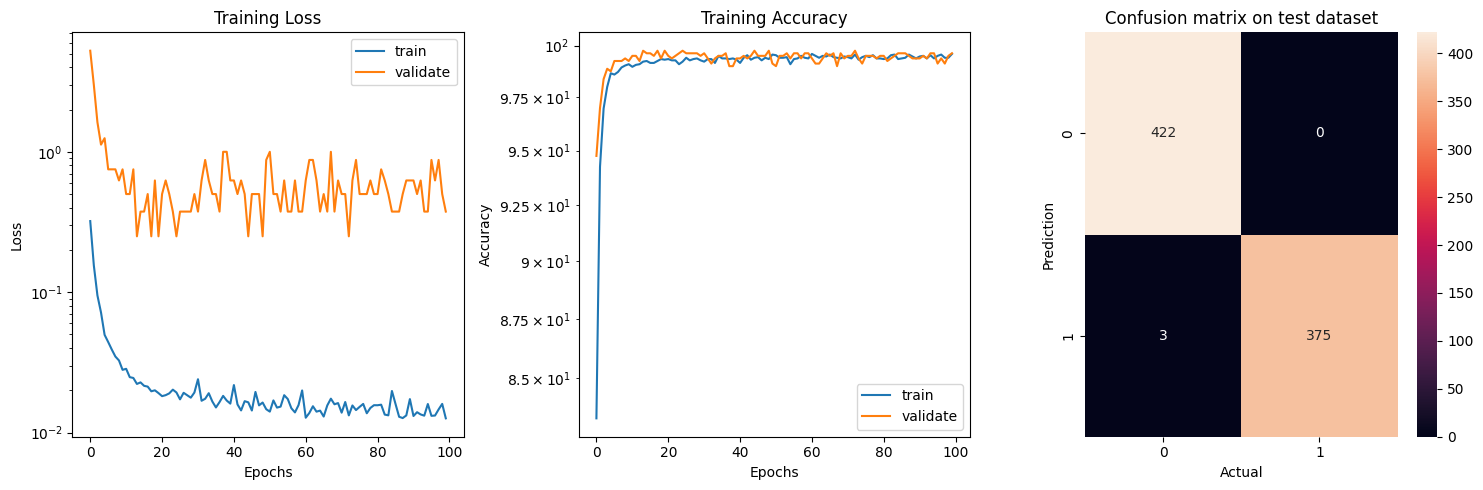

In [16]:
# plot loss, acc, cm
utilities.plot_evaluation_score(
    plot_model.train_loss_per_epoch,
    plot_model.test_loss_per_epoch,
    plot_model.train_acc_per_epoch,
    plot_model.test_acc_per_epoch,
    plot_model.confusion_matrix,
)